In [1]:
import numpy as np
import json
import glob
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt
from collections import defaultdict
import tqdm 
from Bio.PDB import PDBParser
import warnings
import pickle
import dfs_code
warnings.filterwarnings('ignore')

In [2]:
def d2edge_type(d):
    if d<4:
        return 0
    elif d<6:
        return 1
    elif d<8:
        return 2
    else:
        return 3

In [3]:
wiki_aas = {'ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE',
            'SER', 'THR', 'TRP', 'TYR', 'VAL', 'SEC', 'PYL', 'XAA', 'ASX', 'GLX', 'XLE'}
other_idx = len(wiki_aas)

In [4]:
path = "/mnt/ssd/datasets/enzyme/"
node_limit = 200# np.inf
cutoff = 4.5 # 8 also works

In [5]:
glob.glob(path+"*")

['/mnt/ssd/datasets/enzyme/metadata',
 '/mnt/ssd/datasets/enzyme/pdb_files',
 '/mnt/ssd/datasets/enzyme/parsed.json',
 '/mnt/ssd/datasets/enzyme/parsed.pkl',
 '/mnt/ssd/datasets/enzyme/acid2int_leq5.pkl',
 '/mnt/ssd/datasets/enzyme/min_dfs_transformer_preprocessed_leq5.pkl',
 '/mnt/ssd/datasets/enzyme/min_dfs_transformer_preprocessed_n200_dleq4.5.pkl',
 '/mnt/ssd/datasets/enzyme/acid2int_n200.pkl',
 '/mnt/ssd/datasets/enzyme/acid2int.pkl',
 '/mnt/ssd/datasets/enzyme/min_dfs_transformer_preprocessed_n200_dleq10.pkl']

In [6]:
with open(path+"metadata/function_labels.json", "r") as f:
    labels = json.load(f)

In [7]:
with open(path+"metadata/base_split.json", "r") as f:
    split = json.load(f)

In [8]:
with open(path+"parsed.pkl", "rb") as f:
    features = pickle.load(f)

In [9]:
max_dist = 0
max_nodes = 0
nodes = []
selected_keys = []
for prot, feats in tqdm.tqdm(features.items()):
    curr_max = np.max(feats['A'])
    n_nodes = len(feats['A'])
    if n_nodes > max_nodes:
        max_nodes = n_nodes
    if curr_max > max_dist:
        max_dist = curr_max
    if n_nodes <= node_limit:
        selected_keys += [prot] 
    nodes += [n_nodes]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37428/37428 [00:01<00:00, 21600.81it/s]


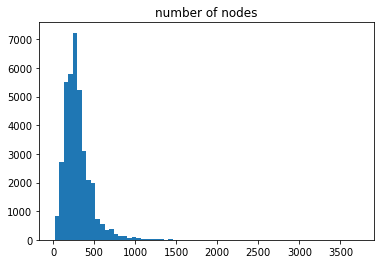

In [10]:
plt.hist(nodes, bins='rice')
plt.title('number of nodes')
plt.show()

In [11]:
n_edges = []
for prot in tqdm.tqdm(selected_keys):
    ds = features[prot]["A"].flatten()
    n_edges += [((ds != 0)*(ds < cutoff)).sum()]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10478/10478 [00:00<00:00, 27595.98it/s]


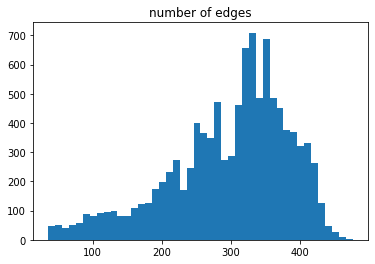

In [12]:
plt.hist(n_edges, bins="rice")
plt.title('number of edges')
plt.show()

In [13]:
bins2 = np.linspace(0, cutoff, 500)
counts2 = np.zeros(len(bins2)-1)

In [14]:
n_edges = []
for prot in tqdm.tqdm(selected_keys):
    ds = features[prot]["A"].flatten()
    counts2 += np.histogram(ds[(ds != 0)*(ds < cutoff)], bins=bins2)[0]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10478/10478 [00:00<00:00, 13988.93it/s]


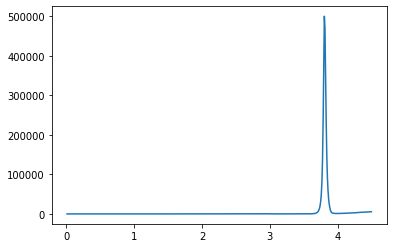

In [15]:
plt.plot(bins2[1:], counts2)

In [16]:
acids = set()
for prot in tqdm.tqdm(selected_keys):
    acids |= set(features[prot]["acid"].tolist())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10478/10478 [00:00<00:00, 75273.00it/s]


In [17]:
acids2int = {acid:idx for idx, acid in enumerate(sorted(list(wiki_aas)))}

In [18]:
graphs = defaultdict(dict)
exceptions = []
for prot in tqdm.tqdm(selected_keys):
    D = features[prot]['A'].copy()
    D -= np.eye(len(D))
    A = (D != -1) * (D < cutoff)
    edge_index = np.asarray(np.where(A))
    edge_index_set = set((e[0], e[1]) for e in edge_index.T)
    node_types = []
    for acid in features[prot]['acid']:
        if acid in acids2int:
            node_types += [acids2int[acid]]
        else:
            node_types += [other_idx]
    node_types = np.asarray(node_types)
    glue_edges = []
    for i in range(len(A)-1):
        if (i, i+1) not in edge_index_set:
            glue_edges += [[i, i+1]]
        if (i+1, i) not in edge_index_set:
            glue_edges += [[i+1, i]]
    if len(glue_edges) > 0:
        glue_edges = np.asarray(glue_edges).T
        edge_index = np.concatenate((edge_index, glue_edges), axis=1)
    edge_types = np.asarray([d2edge_type(D[e[0], e[1]]) for e in edge_index.T])
    min_dfs_code, min_dfs_index = dfs_code.min_dfs_code_from_edgeindex(edge_index, 
                                                                       node_types.tolist(), 
                                                                       edge_types.tolist())
    graphs[prot]['edge_index'] = edge_index
    graphs[prot]['edge_types'] = edge_types
    graphs[prot]['node_types'] = node_types
    graphs[prot]['min_dfs_code'] = min_dfs_code
    graphs[prot]['min_dfs_index'] = min_dfs_index
    graphs[prot]['pos'] = features[prot]['pos']
    del features[prot]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10478/10478 [00:23<00:00, 436.73it/s]


In [19]:
trainset = set(split['train'])
validset = set(split['valid'])
testset = set(split['test'])

In [20]:
for key in graphs.keys():
    graphs[key]['label'] = labels[key]
    if key in trainset:
        graphs[key]['split'] = "train"
    elif key in validset:
        graphs[key]['split'] = "valid"
    elif key in testset:
        graphs[key]['split'] = "test"
    else:
        raise ValueError("unexpected")

In [21]:
with open(path+"restrictive_n%d_dleq%f.pkl"%(node_limit, cutoff), "wb") as f:
    pickle.dump(graphs, f)

In [23]:
with open(path+"acid2int_n%d_dleq%f.pkl"%(node_limit, cutoff), "wb") as f:
    pickle.dump(acids2int, f)

In [24]:
acids2int

{'ALA': 0,
 'ARG': 1,
 'ASN': 2,
 'ASP': 3,
 'ASX': 4,
 'CYS': 5,
 'GLN': 6,
 'GLU': 7,
 'GLX': 8,
 'GLY': 9,
 'HIS': 10,
 'ILE': 11,
 'LEU': 12,
 'LYS': 13,
 'MET': 14,
 'PHE': 15,
 'PYL': 16,
 'SEC': 17,
 'SER': 18,
 'THR': 19,
 'TRP': 20,
 'TYR': 21,
 'VAL': 22,
 'XAA': 23,
 'XLE': 24}